# 머신러닝 오버샘플링 & 언더샘플링 실습 : kaggle credit_card_fraud 데이터 활용
* ref : https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings(action='ignore')

### 필요 API

In [2]:
def myscore(y_test,pred,proba, pr_curve=0, auc_curve=0):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test, proba[:,-1])
    print("Accuracy:{:.6f}  precision:{:.6f}, recall:{:.6f}, f1:{:.6f}, auc:{:.6f}".format(accuracy, precision, recall, f1, auc))

    mtx = confusion_matrix(y_test, pred)
    print(mtx)
    
    if pr_curve==1:
        mycurve(y_test, proba)
    if auc_curve==1:
        mycurve_auc(y_test, proba)
        

In [3]:
def mysplit(df, test_size=0.3) :
    df_X = df.iloc[:, :-1]
    df_y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=test_size, random_state=0, stratify=df_y)   #------Stratified 기반 분할 (균등분할)
    return  X_train, X_test, y_train, y_test

In [4]:
from sklearn.metrics import precision_recall_curve
def mycurve(y_test, proba):  
    precision, recall, thresholds = precision_recall_curve(y_test, proba[ : , -1])
    print(len(precision), len(recall), len(thresholds))  #66 66 65
    plt.plot(thresholds, precision[:len(thresholds)], label="precision")
    plt.plot(thresholds, recall[:len(thresholds)], label="recall")
    plt.xlabel("thresholds")
    plt.ylabel("score")
    plt.grid()
    plt.legend()
    plt.show()
    

In [5]:
def mycurve_auc(y_test, proba):  
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,-1])
    print(len(fpr), len(tpr), len(thresholds))  #66 66 65
    plt.plot(fpr, tpr, label="roc")
    plt.plot([0,1], [0,1], label="th:0.5")
    plt.xlabel("FPR (1-TNR(specificity)")      #FP
    plt.ylabel("TPR (recall,sensitivity)") #TP
    plt.title(f"auc : {roc_auc_score(y_test, proba[:,-1]):.4f}")
    plt.grid()
    plt.legend()
    plt.show()

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcAqc6V%2FbtqyQLiddUd%2FiXQVu1nYTo2rx3Q8xZBqy0%2Fimg.png" width=600 height=400>

In [6]:
def myoutlier(df=None, column=None, weight=1.5):
    df = df[df['Class']==1][column]
    p25 = np.percentile(df.values, 25)
    p75 = np.percentile(df.values, 75)
    IQR = (p75 - p25) * weight
    low_limit  = p25 - IQR
    high_limit = p75 + IQR
    outlier_idx = df[(df < low_limit) | (df > high_limit)].index.values.tolist()
    return outlier_idx

### 1. data collection

In [8]:
df = pd.read_csv('creditcard.csv')

### 2. EDA

In [9]:
df.info()
#결측 없음. 전부 수치형 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### target 불균형 확인

In [11]:
df["Class"].value_counts() #타겟 불균형 확인

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

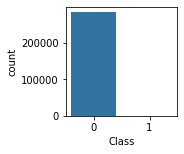

In [12]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.countplot('Class', data=df, ax=ax)

#### 카테고리성 피쳐 확인

In [13]:
oh_numeric_feature = []
for col in df.columns:
    if df[col].nunique() <= 40:
        print(col, df[col].unique())
        oh_numeric_feature.append(col)

Class [0 1]


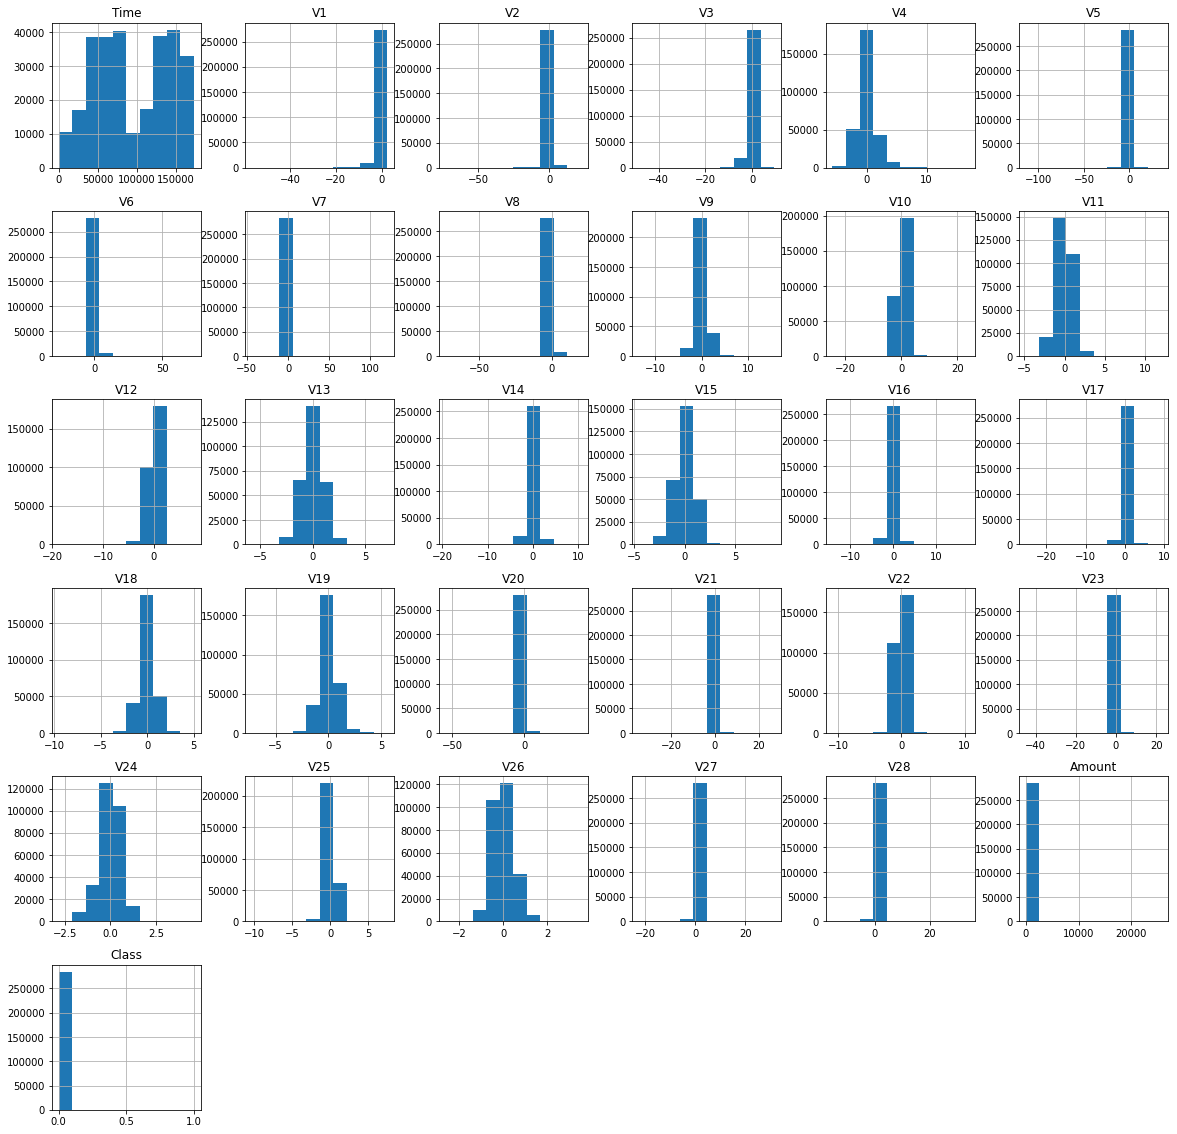

In [16]:
df.hist(figsize=(20,20))
plt.show()

#### 0데이터 확인

In [17]:
nan_dict = {"CNT":df.isin([0]).sum(),
            "RATE": df.isin([0]).sum()/df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))

           CNT       RATE
Class   284315  99.827251
Amount    1825   0.640785
Time         2   0.000702


#### missing value

In [18]:
# df.isna().sum()>0
nan_dict = {"CNT":df.isna().sum(),
            "RATE": df.isna().sum()/df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))

Empty DataFrame
Columns: [CNT, RATE]
Index: []


#### 상관분석

<AxesSubplot:>

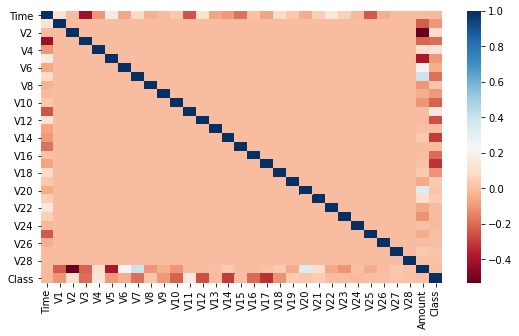

In [19]:
plt.figure(figsize=(9, 5))
sns.heatmap(df.corr(), cmap='RdBu')

<pre>
* positive :  V11, V4, V2, V21
    V11       0.154876
    V4        0.133447
    V2        0.091289
    V21       0.040413
* Negative : V17, V14, V12, V10, V16
    V7       -0.187257
    V3       -0.192961
    V16      -0.196539
    V10      -0.216883
    V12      -0.260593
    V14      -0.302544
    V17      -0.326481
</pre>

In [20]:
df.corrwith(df["Class"]).sort_values(ascending=False) #Class데이터와의 상관관계 확인

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
dtype: float64

#### Outlier 확인

* Boxplots

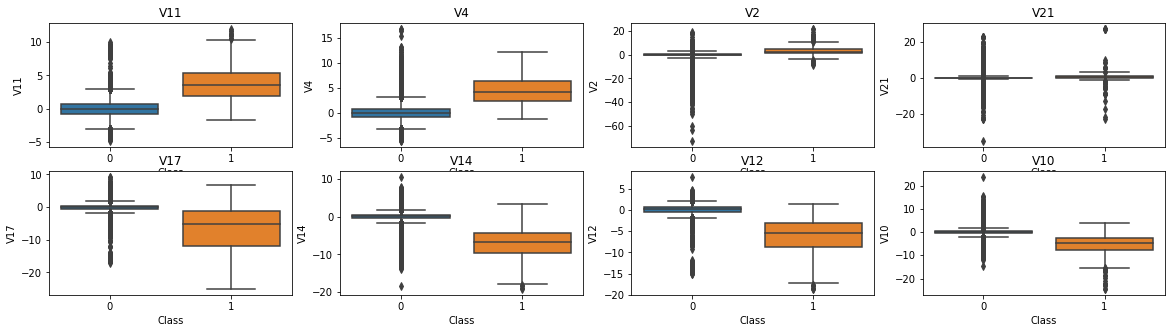

In [21]:
positive=['V11', 'V4', 'V2', 'V21']
negative=['V17', 'V14', 'V12', 'V10'] #, 'V16']
pos_neg = positive + negative
# print(cols)
f, axes = plt.subplots(2,4, figsize=(20,5))
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][0])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][1])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][2])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][3])

# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][0])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][1])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][2])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][3])

for i, feature in enumerate(pos_neg):
    cols = i%4
    rows = i//4     
    sns.boxplot(x="Class", y=feature, data=df, ax=axes[rows][cols])
    axes[rows][cols].set_title(feature)

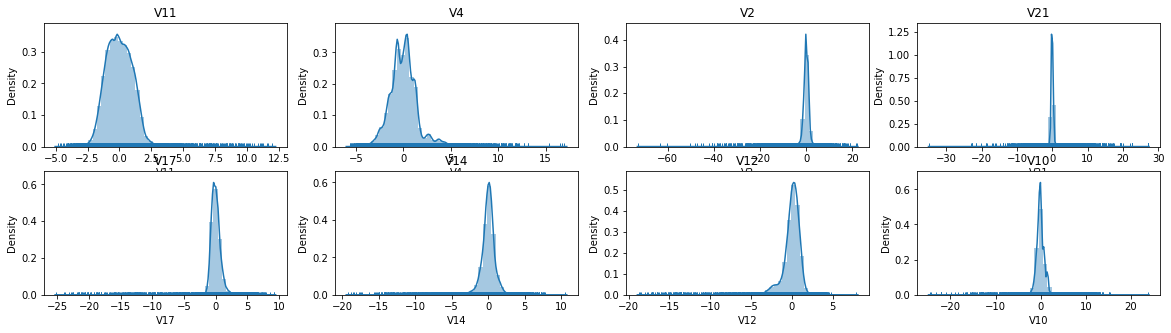

In [22]:
positive=['V11', 'V4', 'V2', 'V21']
negative=['V17', 'V14', 'V12', 'V10'] #, 'V16']
pos_neg = positive + negative
# print(cols)
f, axes = plt.subplots(2,4, figsize=(20,5))
for i, feature in enumerate(pos_neg):
    cols = i%4
    rows = i//4     
    sns.distplot(df[feature], kde=True, rug=True, ax=axes[rows][cols])
    axes[rows][cols].set_title(feature)
    

* IQR 이용

In [23]:
# col_idx = myoutlier(df=df, column='V11', weight=1.5)
for col in pos_neg:
    res = myoutlier(df=df, column=col, weight=1.5)
    print(col,  len(res), "\t\t", res)

V11 10 		 [8296, 8335, 8615, 9035, 9179, 9252, 9487, 9509, 10568, 10801]
V4 0 		 []
V2 46 		 [14211, 15166, 15204, 15225, 15451, 15476, 15506, 15539, 15566, 15736, 15751, 15781, 15810, 16780, 17317, 17366, 17407, 17453, 17480, 33276, 82400, 83297, 102441, 102442, 102443, 102444, 102445, 102446, 151006, 151007, 151008, 151009, 151462, 151519, 152223, 152295, 153823, 153835, 154234, 154371, 154587, 154684, 176049, 249607, 258403, 274382]
V21 49 		 [10801, 10891, 10897, 11343, 11710, 11841, 11880, 12070, 12108, 12261, 12369, 42958, 43204, 44223, 44270, 77682, 102441, 102442, 102443, 102444, 102445, 102446, 144754, 149145, 149600, 151006, 151007, 151008, 151009, 151011, 151462, 151519, 151730, 151807, 152019, 152223, 152295, 153823, 153835, 153885, 154234, 154371, 154587, 154684, 167184, 167305, 189878, 231978, 272521]
V17 0 		 []
V14 4 		 [8296, 8615, 9035, 9252]
V12 6 		 [8296, 8615, 150601, 150644, 150647, 150654]
V10 19 		 [44223, 44270, 150679, 150680, 150697, 151006, 151007, 151008, 

#### Time Amount 확인

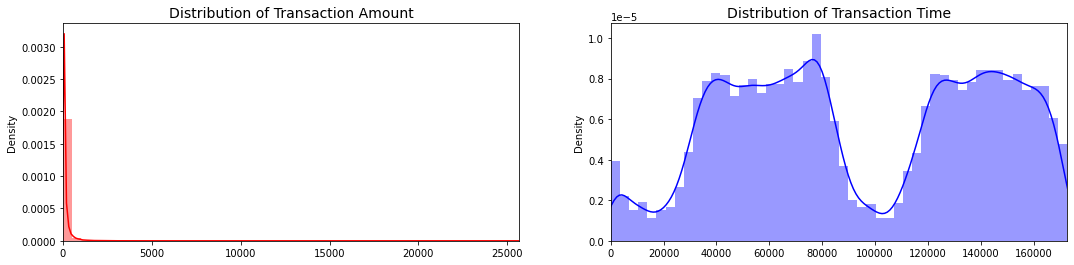

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

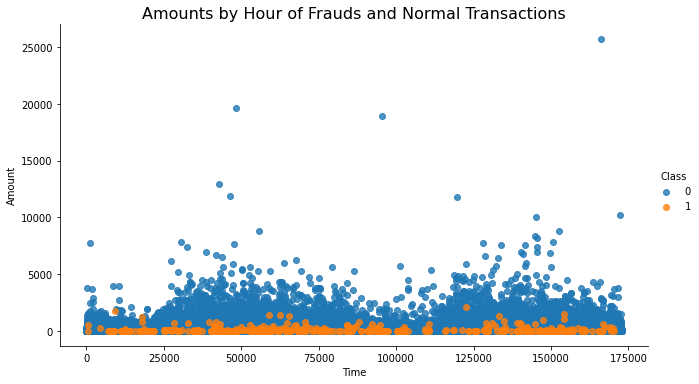

In [25]:
ax = sns.lmplot(y="Amount", x="Time", fit_reg=False, aspect=1.8, data=df, hue='Class')
plt.title("Amounts by Hour of Frauds and Normal Transactions", fontsize=16)
plt.show()

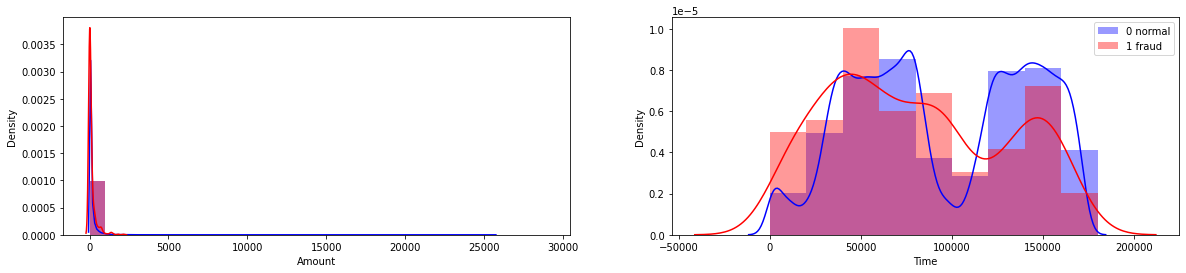

In [26]:
fig, axes = plt.subplots(figsize=(20, 4), ncols=2)
# plt.xticks(range(0, 30000, 1000), rotation=60)

bins = np.arange(0, 30000, 1000)
sns.distplot(df[df['Class']==0]['Amount'] , ax=axes[0], bins=bins, color='b', label='0 normal')
sns.distplot(df[df['Class']==1]['Amount'] , ax=axes[0], bins=bins, color='r', label='1 fraud')

bins = np.arange(0, 200000, 20000)
sns.distplot(df[df['Class']==0]['Time'] , ax=axes[1], bins=bins, color='b', label='0 normal')
sns.distplot(df[df['Class']==1]['Time'] , ax=axes[1], bins=bins, color='r', label='1 fraud')

plt.legend()
plt.show()

# 전처리 & 가공

In [27]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

sacler_val = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.insert(0, 'T_Amount', sacler_val)

sacler_val = np.log1p(df['Amount'])
df.insert(0, 'T_Amount2', sacler_val)

df.drop(['Time','Amount', 'T_Amount'], axis=1, inplace=True)


In [28]:
df.head()

,T_Amount2,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,5.014760,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.305626,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,5.939276,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,4.824306,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,4.262539,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# 분석 모델

### 점수 확인

In [29]:
X_train, X_test, y_train, y_test = mysplit(df)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(199364, 29) (85443, 29) 199364 85443


In [30]:
y_test.value_counts()

0    85295
1      148
Name: Class, dtype: int64

In [31]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [32]:
lr = LogisticRegression(random_state = 36)
lr.fit(X_train,y_train)
pred_lr = lr.predict(X_test)
proba_lr = lr.predict_proba(X_test)
myscore(y_test, pred_lr, proba_lr)

Accuracy:0.999169  precision:0.881188, recall:0.601351, f1:0.714859, auc:0.972683
[[85283    12]
 [   59    89]]


Accuracy:0.999216  precision:0.783217, recall:0.756757, f1:0.769759, auc:0.878197
[[85264    31]
 [   36   112]]
3 3 2


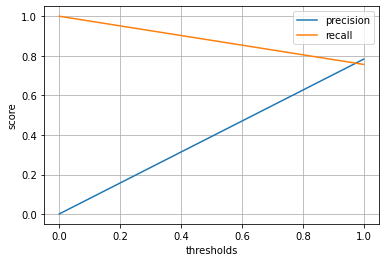

3 3 3


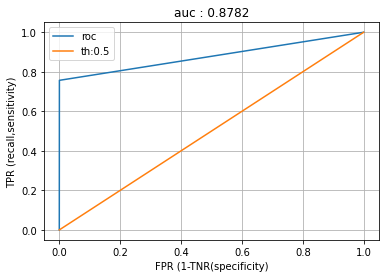

In [33]:
dt = DecisionTreeClassifier(random_state = 36)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
proba_dt = dt.predict_proba(X_test)
myscore(y_test, pred_dt, proba_dt, pr_curve=1, auc_curve=1)

## 언더 샘플링

In [36]:
from imblearn.over_sampling  import SMOTE 
from imblearn.under_sampling import NearMiss
from imblearn.metrics  import classification_report_imbalanced
from sklearn.metrics   import classification_report
from sklearn.pipeline  import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.utils     import shuffle

X_train, X_test, y_train, y_test = mysplit(df)
X_train_NearMiss, y_train_NearMiss = NearMiss().fit_resample(X_train.values, y_train.values)
y, counts = np.unique(y_train_NearMiss, return_counts=True)
print(y, counts)

[0 1] [344 344]


## 언더샘플링 (셔플 과정)

<AxesSubplot:>

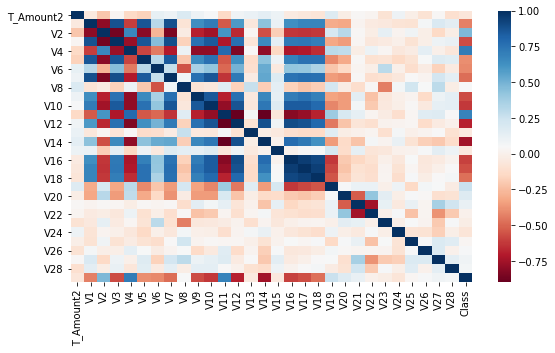

In [49]:
#상관분석 히트맵 이미지 확인

# Shuffle 언더프레임
df = df.sample(frac=1)   #shuffle
df1 = df.loc[df['Class'] == 1]
df0 = df.loc[df['Class'] == 0][:len(df1)]
under_df_f1f0 = pd.concat([df1, df0])
under_df = under_df_f1f0.sample(frac=1, random_state=42)

plt.figure(figsize=(9, 5))
sns.heatmap(under_df.corr(), cmap='RdBu') ###상관도가 너무 높아짐.

Accuracy:0.922297  precision:0.956204, recall:0.885135, f1:0.919298, auc:0.981373
[[142   6]
 [ 17 131]]
211 211 210


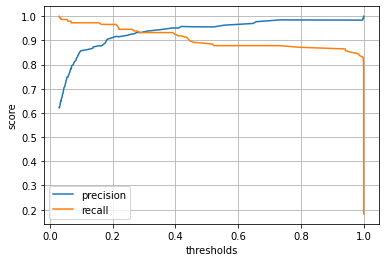

29 29 29


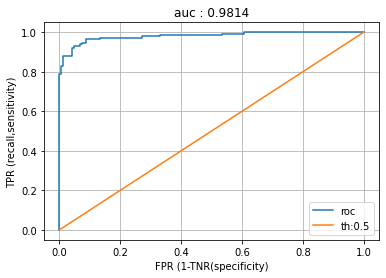

In [52]:
X_train, X_test, y_train, y_test = mysplit(under_df)

lr = LogisticRegression(random_state = 36)
lr.fit(X_train,y_train)
pred_lr = lr.predict(X_test)
proba_lr = lr.predict_proba(X_test)
myscore(y_test, pred_lr, proba_lr, pr_curve=1, auc_curve=1) 

Accuracy:0.898649  precision:0.888158, recall:0.912162, f1:0.900000, auc:0.898649
[[131  17]
 [ 13 135]]
3 3 2


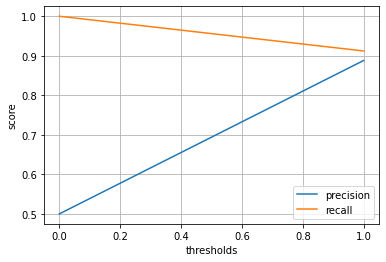

3 3 3


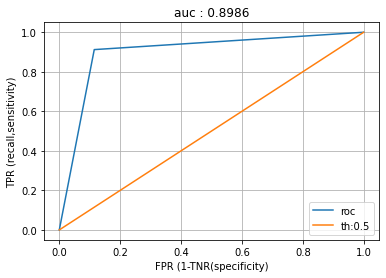

In [57]:
dt = DecisionTreeClassifier(random_state = 36)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
proba_dt = dt.predict_proba(X_test)
myscore(y_test, pred_dt, proba_dt, pr_curve=1, auc_curve=1) 

## 오버 샘플링

In [76]:
X_train, X_test, y_train, y_test = mysplit(df)

smote = SMOTE(random_state=0)
print('SMOTE 적용 전 X_train ', X_train.shape, y_train.shape) ##어레이 형태
X_train_over, y_train_over = SMOTE(random_state=0).fit_resample(X_train, y_train)
print('SMOTE 적용 후 X_train_over: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 y_train_over:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 X_train  (199364, 29) (199364,)
SMOTE 적용 후 X_train_over:  (398040, 29) (398040,)
SMOTE 적용 후 y_train_over:
 0    199020
1    199020
Name: Class, dtype: int64


Accuracy:0.972918  precision:0.055419, recall:0.912162, f1:0.104489, auc:0.974505
[[82994  2301]
 [   13   135]]
72976 72976 72975


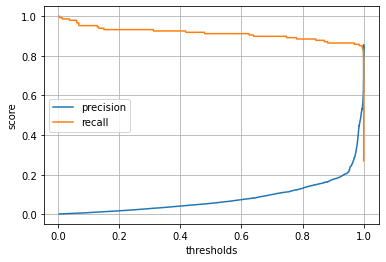

1688 1688 1688


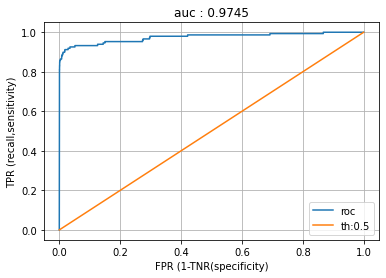

In [77]:
lr = LogisticRegression(random_state = 36)
lr.fit(X_train_over,y_train_over)
pred_lr = lr.predict(X_test)
proba_lr = lr.predict_proba(X_test)
myscore(y_test, pred_lr, proba_lr, pr_curve=1, auc_curve=1)  #FP가 높다. 불안정한 모델.

Accuracy:0.997893  precision:0.437984, recall:0.763514, f1:0.556650, auc:0.880907
[[85150   145]
 [   35   113]]
3 3 2


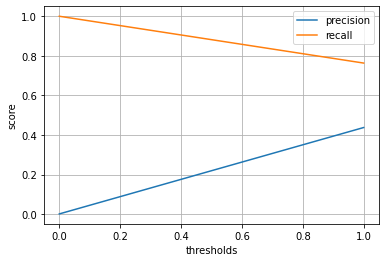

3 3 3


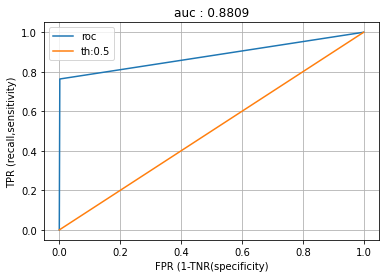

In [78]:
dt = DecisionTreeClassifier(random_state = 36)
dt.fit(X_train_over, y_train_over)
pred_dt = dt.predict(X_test)
proba_dt = dt.predict_proba(X_test)
myscore(y_test, pred_dt, proba_dt, pr_curve=1, auc_curve=1) 

## 결론
- 언더샘플링은 오버피팅이 날 수 밖에 없다 >> 점수는 잘 나오지만 예측 불가
- 오버샘플링은 모델이 불안정하다고 표현 >> 실제로 데이터 불균형을 해소하기 위해 사용됨.